# Backtest Analysis

## Introduction

Below is a simple backtest analysis. For this, vectorbt was chosen as the backtesting library due to it's robust vectorization library. Backtest strategies can be found in the Backtest Models module. In the each test, a portfolio of assets are chosen with a 100K total cash amount.

The first backtest utilizes a Moving Average crossover strategy for momentum. 1000 randomly generated splits are chosen and the distribution of the Sharpe Ratio for the strategy is shown. The second backtest utilizes a Moving Average crossover strategy with longs and shorts, using the same 100 randomly generated splits, along with it's distribution of Sharpe Ratios. The third backtest utilizes RSI as a mean reversion strategy using the same splits along with it's distribution.

There are additional strategy options built into the vectorbt toolkit like stop-loss and slippage, but for the purpose of these analyses these are omitted. In many of the portfolio options this is available for readers interested in 
building off the code.

## Benchmarks and Statistical Test Targets

There is a wide discussion of utilization of Sharpe Ratios in fund targeting and its distribution (see [Lo](https://traders.studentorg.berkeley.edu/papers/The-Statistics-of-Sharpe-Ratios.pdf)). Below, each strategy compares the average Sharpe Ratio of the strategy to the average Sharpe Ratio of the long only strategy for BTC for the periods and reports them, as well as kurtosis measures and skew. Readers should be aware that it is not statistically sound to compare Share Ratios in this way, but information is added for the purpose of the report.

An additional feature of the library is ability to compute the portfolio's maximum drawdowns. These are included below.


In [1]:
from Backtest.models.MomentumAnalysis import MomentumAnalysis
from Backtest.models.MeanReversionAnalysis import MeanReversionAnalysis
from Backtest.models.PairTradeAnalysis import PairTradeAnalysis, generate_pairs
import vectorbt as vbt
import pandas as pd
import numpy as np

from Backtest.models.Analysis import plot_statistics, plot_table_statistics

np.random.seed(1337)

# Backtests

## Data Prep

Below the code takes BTC, SOL, BNB, and ETH, as well as the 1000 It also generates the benchmark table of returns holding just BTC used in Analysis comparison. Note SOL wasn't started as a datasource until 2020 in Yahoo, but the system should handle the portfolio data correctly.

In [2]:
btc_price = vbt.YFData.download("BTC-USD", start="2019-01", end="2024-07").get("Close")
sol_price = vbt.YFData.download("SOL-USD", start="2019-01", end="2024-07").get("Close")
bnb_price = vbt.YFData.download("BNB-USD", start="2019-01", end="2024-07").get("Close")
eth_price = vbt.YFData.download("ETH-USD", start="2019-01", end="2024-07").get("Close")

comb_price = pd.concat([btc_price, eth_price, sol_price, bnb_price],

    keys=pd.Index(['BTC', 'ETH', 'BNB', 'SOL']), axis=1)

_, date_splits = btc_price.dropna().vbt.range_split(n=1000, range_len=360)

btc_price_sharpes = [
    btc_price[date_split].pct_change().vbt.returns.sharpe_ratio()
    for date_split in date_splits
]

For comparison, the BTC return Sharpe Statistics are below.

In [3]:
target_sharpe = np.mean(btc_price_sharpes)

plot_table_statistics(btc_price_sharpes)

On average, we get a Sharp ratio of about 0.986 for holding just BTC, but with a standard deviation of around 1.25. Note these Sharpe ratios are for 1 year holding periods.

## Long Only Momentum

For this analysis, the Momentum Analysis library is used Backtest module. The library uses a Moving Average strategy where if the 15 day MA crosses above 50 day MA, the strategy goes long, and vice versa for moving below.

Note the time splits are only for 1 year and 1000 simulated portfolios are generated with initial cash of 100000 USD.

In [4]:
momentum_long_analyses = []
for split in date_splits:
    analysis = MomentumAnalysis(comb_price.reindex(split))
    analysis.MomentumBasedLongOnly()
    momentum_long_analyses.append(analysis)

As a sanity check, we can select one of the portfolios and use vectorbt's built in visualization tools to check the strategy's performance and orders. Below is the plot for orders for a particular asset, and below that is the returns over time. The orders for each portfolio and asset can be fetched if needed.

In [5]:
momentum_long_analyses[0].portfolio.plot_orders((15, 50, 'SOL'))

FigureWidget({
    'data': [{'line': {'color': '#1f77b4'},
              'name': 'Close',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'fe219e5b-422f-45bc-b569-a293352b69fd',
              'x': array([datetime.datetime(2019, 1, 13, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2019, 1, 14, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2019, 1, 15, 0, 0, tzinfo=datetime.timezone.utc), ...,
                          datetime.datetime(2020, 1, 5, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2020, 1, 6, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2020, 1, 7, 0, 0, tzinfo=datetime.timezone.utc)],
                         dtype=object),
              'y': array([ 5.56875706,  6.15928221,  5.91904783, ..., 14.11101913, 14.95780754,
                          15.00924969])},
             {'customdata': array([[ 

In [6]:
momentum_long_analyses[0].portfolio.plot_value()

FigureWidget({
    'data': [{'hoverinfo': 'skip',
              'line': {'color': 'rgba(0, 0, 0, 0)', 'width': 0},
              'opacity': 0,
              'showlegend': False,
              'type': 'scatter',
              'uid': '5fc34d21-79f1-4065-81d2-a46f0a9ba174',
              'x': array([datetime.datetime(2019, 1, 13, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2019, 1, 14, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2019, 1, 15, 0, 0, tzinfo=datetime.timezone.utc), ...,
                          datetime.datetime(2020, 1, 5, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2020, 1, 6, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2020, 1, 7, 0, 0, tzinfo=datetime.timezone.utc)],
                         dtype=object),
              'y': array([100000., 100000., 100000., ..., 100000., 100000., 100000.])},
             {'connectgaps': Fals

Below are the results of the 1000 portfolios and their Sharpe ratio.

In [7]:
momentum_long_sharpes = [analysis.portfolio.sharpe_ratio() for analysis in momentum_long_analyses]
plot_statistics(momentum_long_sharpes, title="Sharpe Distribution for Momentum Long Only Strategy", target=target_sharpe)

Also below, the distribution of maximum drawdown in the portfolio is shown.

In [8]:
momentum_long_max_drawdowns = [analysis.portfolio.max_drawdown() for analysis in momentum_long_analyses]
plot_statistics(momentum_long_max_drawdowns, title="Max Drawdown Distribution for Momentum Long Only Strategy")
plot_table_statistics(momentum_long_max_drawdowns)

In [9]:
plot_table_statistics(momentum_long_sharpes)

With an average Sharpe ratio of 0.47, this strategy doesn't look very profitable compared to buying and holding, which had an average Sharpe ratio of 0.97.

Below is also a look at the statistics of the drawdowns maximum duration where we can see an average max drawdown duration of 187 days. While this is an interesting statistic, I'm not sure if it has any real
value as it's variance is high and min/max is wide.

In [10]:
momentum_long_drawdowns_duration = [analysis.portfolio.drawdowns.duration.max() for analysis in momentum_long_analyses]
plot_table_statistics(momentum_long_drawdowns_duration)

Last, below are statistics on returns. The returns are highly non-normal and clearly fat-tailed, so they should not be used in investment decisions.

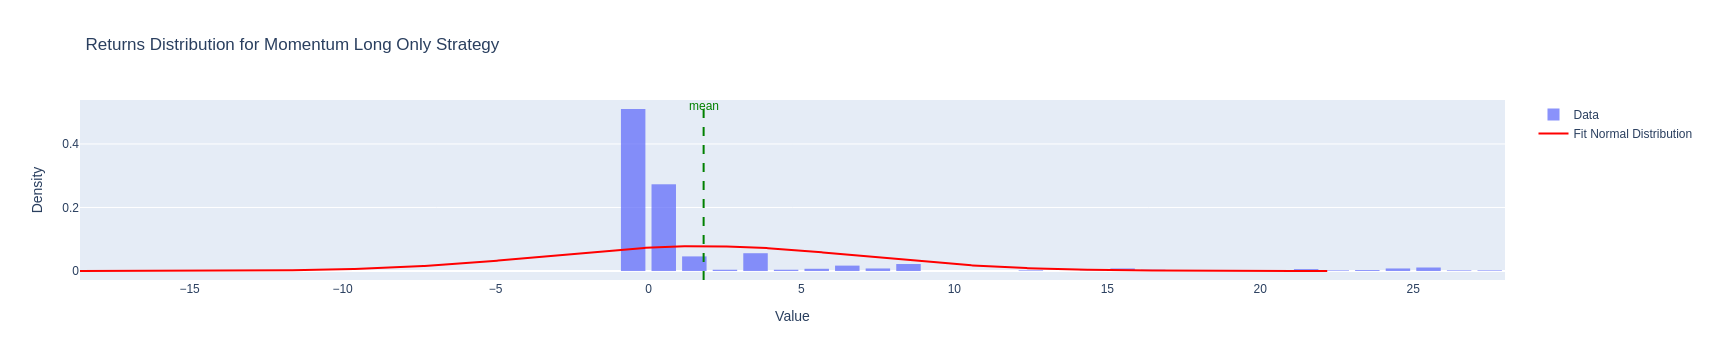

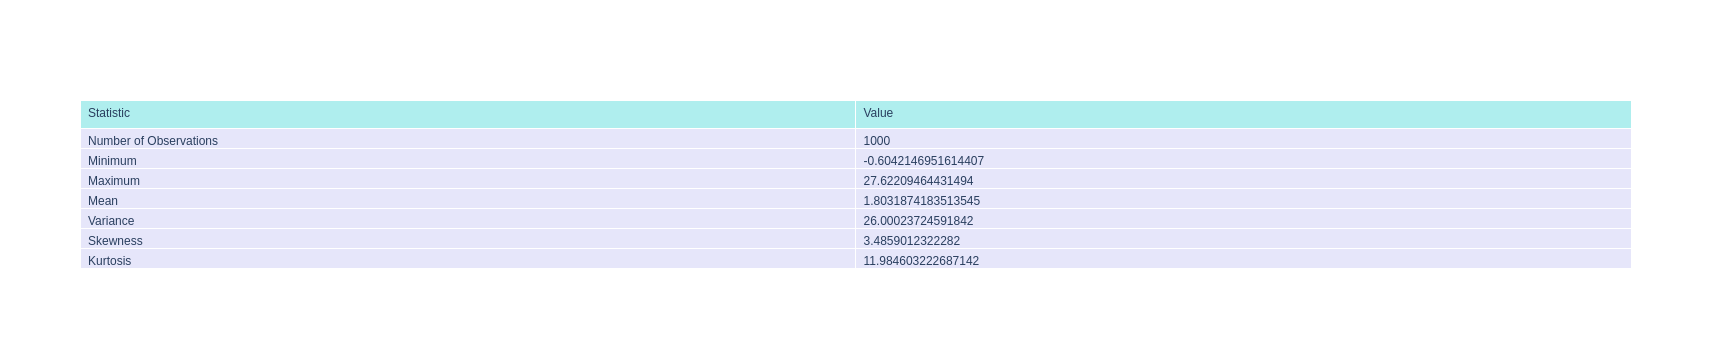

In [11]:
momentum_long_returns = [analysis.portfolio.total_return() for analysis in momentum_long_analyses]
plot_statistics(momentum_long_returns, title="Returns Distribution for Momentum Long Only Strategy")
plot_table_statistics(momentum_long_returns)

## Long-Short Momentum

Below the same analysis is done, but this time with a long and short strategy. When the MA is crossed, the portfolio simulates longing when the 15 day moving average is above the 50, and vice versa.

In [12]:
momentum_ls_analyses = []
for split in date_splits:
    analysis = MomentumAnalysis(comb_price.reindex(split))
    analysis.MomentumBasedLongShort()
    momentum_ls_analyses.append(analysis)

Again, we can look at the distribution of Sharpe ratios and compare the statistics to the benchmark of spot Bitcoin's average Sharpe ratio.

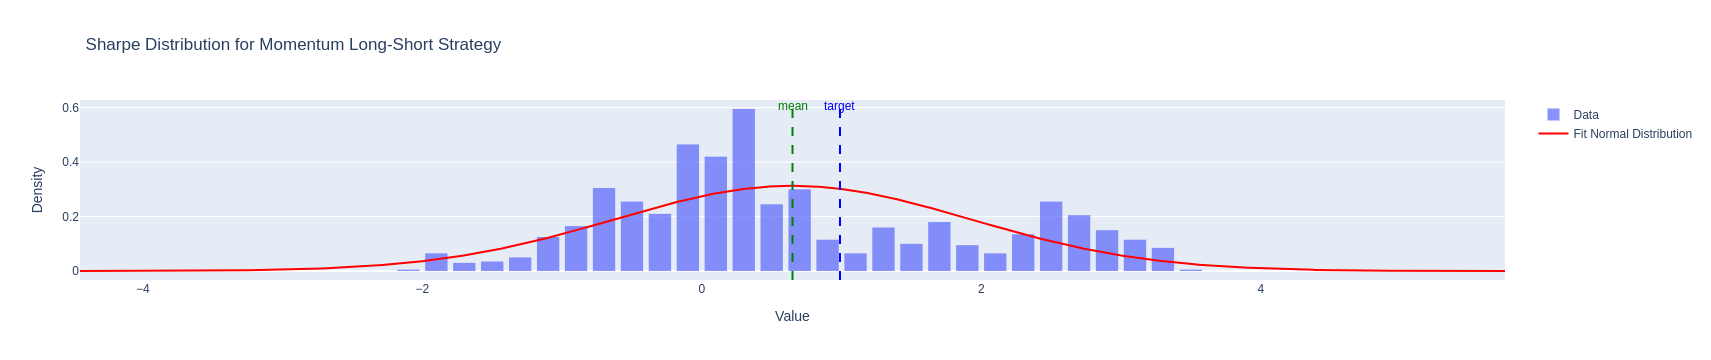

In [13]:
momentum_ls_sharpes = [analysis.portfolio.sharpe_ratio() for analysis in momentum_ls_analyses]
plot_statistics(momentum_ls_sharpes, title="Sharpe Distribution for Momentum Long-Short Strategy", target=target_sharpe)

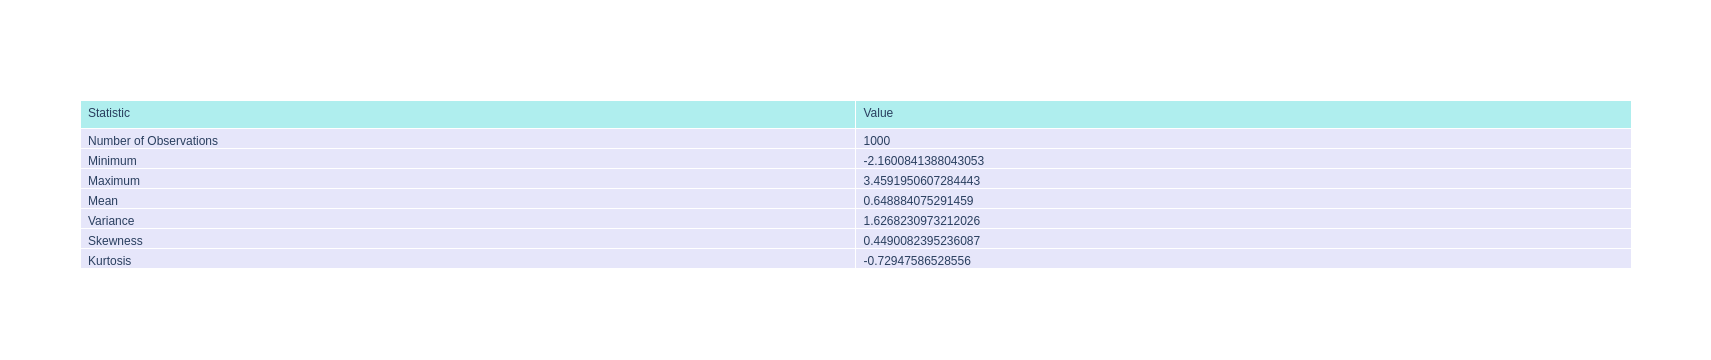

In [14]:
plot_table_statistics(momentum_ls_sharpes)

Above in the table, the average Sharpe ratio is 0.655, which is slightly better than the Long only strategy, but still not comparable to spot Bitcoin.

## Mean Reversion

This backtes set uses RSI to generate Mean Reversion signals. The settings are defined in the MeanReversionAnalysis class, but the code takes RSI > 70 to be overbought, and sells the assets then, and an RSI below 30 to be oversold, and longs the assets. As in the mean reversion above, one could also include the overbought and short, but this is not included in the analysis.

In [15]:
mr_analyses = []
for split in date_splits:
    analysis = MeanReversionAnalysis(comb_price.reindex(split))
    analysis.MeanReversionBasedLongOnly()
    mr_analyses.append(analysis)

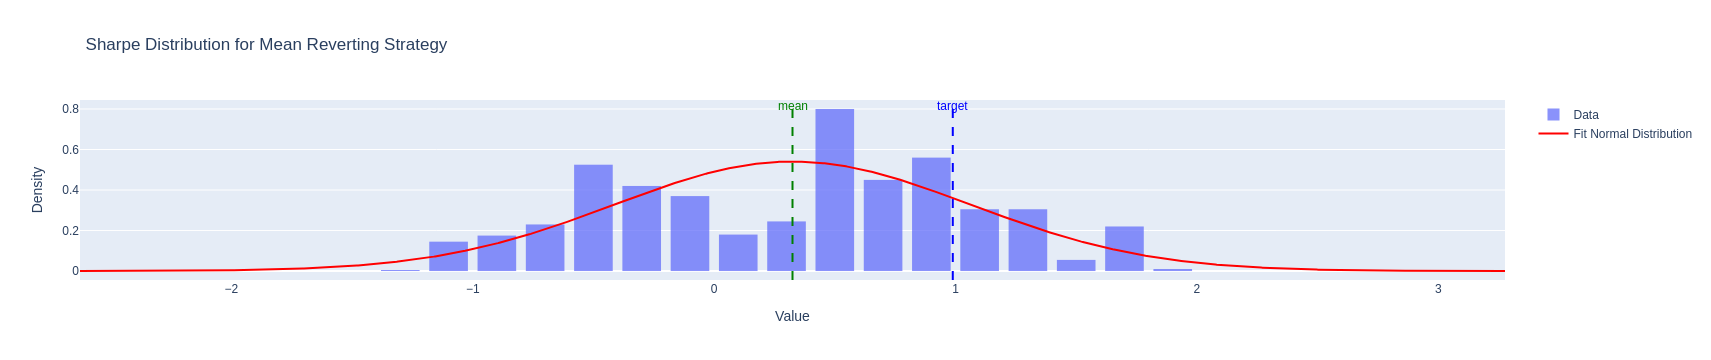

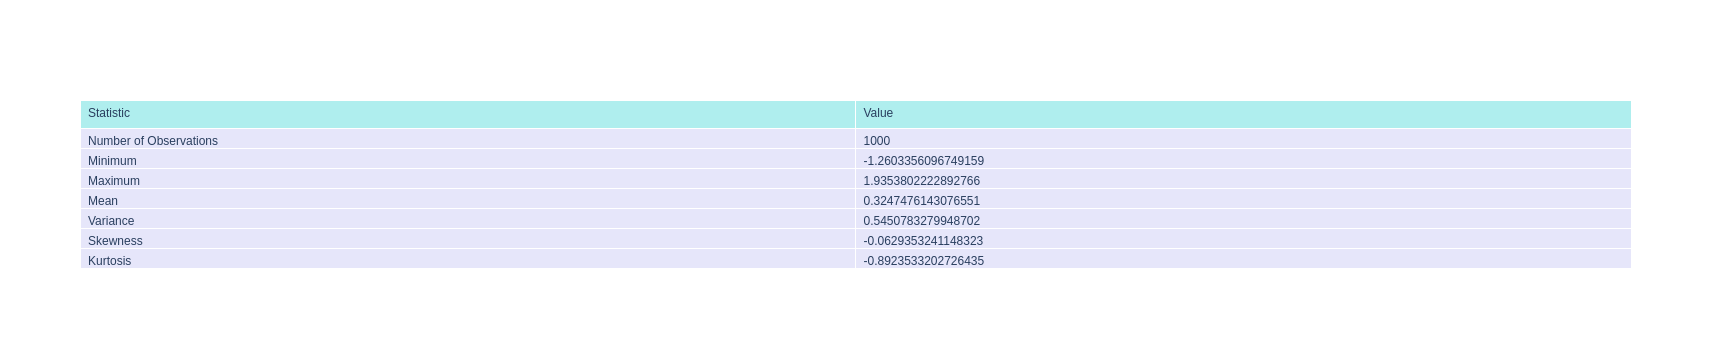

In [16]:
mr_long_sharpes = [analysis.portfolio.sharpe_ratio() for analysis in mr_analyses]
plot_statistics(mr_long_sharpes, title="Sharpe Distribution for Mean Reverting Strategy", target=target_sharpe)
plot_table_statistics(mr_long_sharpes)

Above it's shown that mean Sharpe ratio is 0.32, which is close to the Momentum long only analysis but still underperforming on average than spot BTC.

## Pair Trade Analysis

To test a custom strategy, below uses a pair trade analysis. First, we generate highly correlated pairs in the dataset.
Note the dataset is not super large, but we can infer BTC and ETH are highly correlated. The code in Pair Trade Analysis can take any dataset and generate a correlation of daily returns, and uses a threshold of 0.7 positive correlation to select assets.

In [17]:
generate_pairs(comb_price)

[('BTC', 'ETH')]

The actual strategy is computed in the PairTradeAnalysis class, but in simple terms:

- If one asset goes up faster than the other, short it and long the other.
-  If one asset goes down faster than the other, long it and short the other.

This generates an interesting sequence of positions where one asset is always long and the other is short based on how far they have diverged and assuming they will regress towards a similar mean return.

In [18]:
pair_analyses = []
for split in date_splits:
    analysis = PairTradeAnalysis(comb_price.reindex(split))
    analysis.PairCorrLongOnly(("BTC", "ETH"))
    pair_analyses.append(analysis)

Below are plots of Sharpe ratio distribution and max drawdowns for the 1000 simulated backtests. It is shown that the strategy is quite close to target.

In [19]:
pair_long_sharpes = [analysis.portfolio.sharpe_ratio() for analysis in pair_analyses]

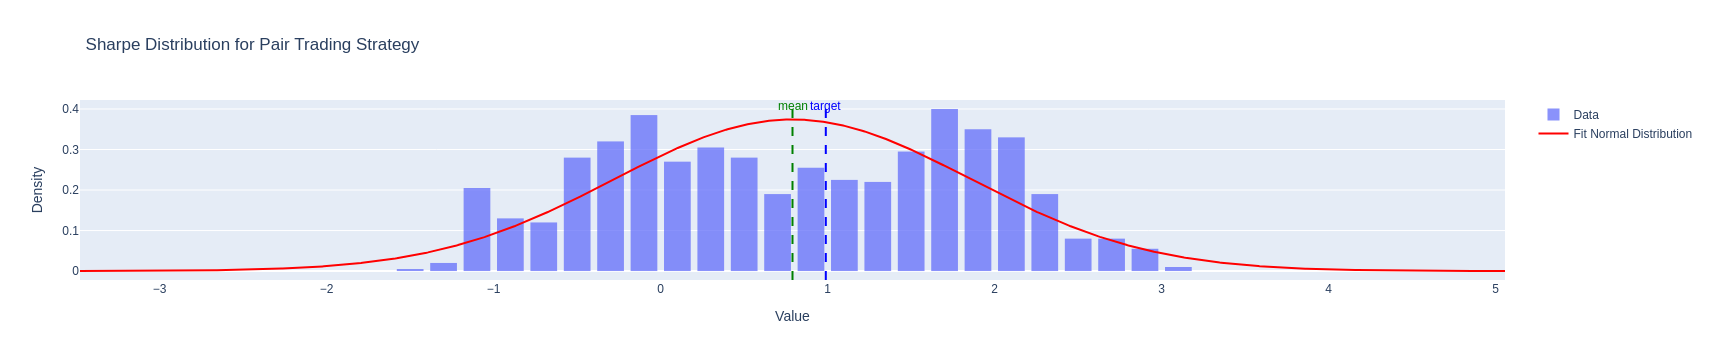

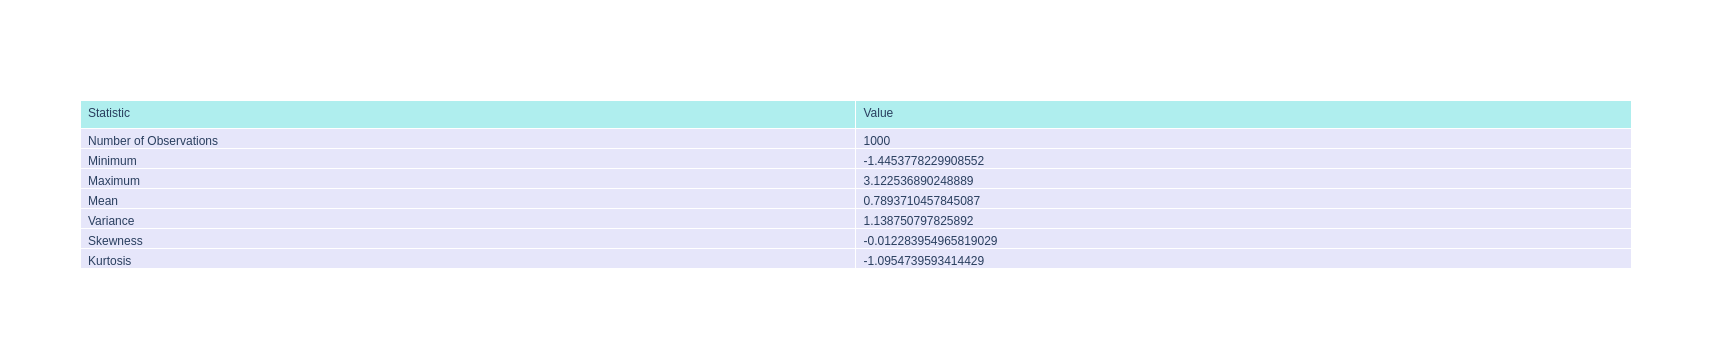

In [20]:
plot_statistics(pair_long_sharpes, title="Sharpe Distribution for Pair Trading Strategy", target=target_sharpe)
plot_table_statistics(pair_long_sharpes)

Below is the max drawdowns distribution. It shows an average drawdown of 49% across multiple simulations, which is expected for a strategy.

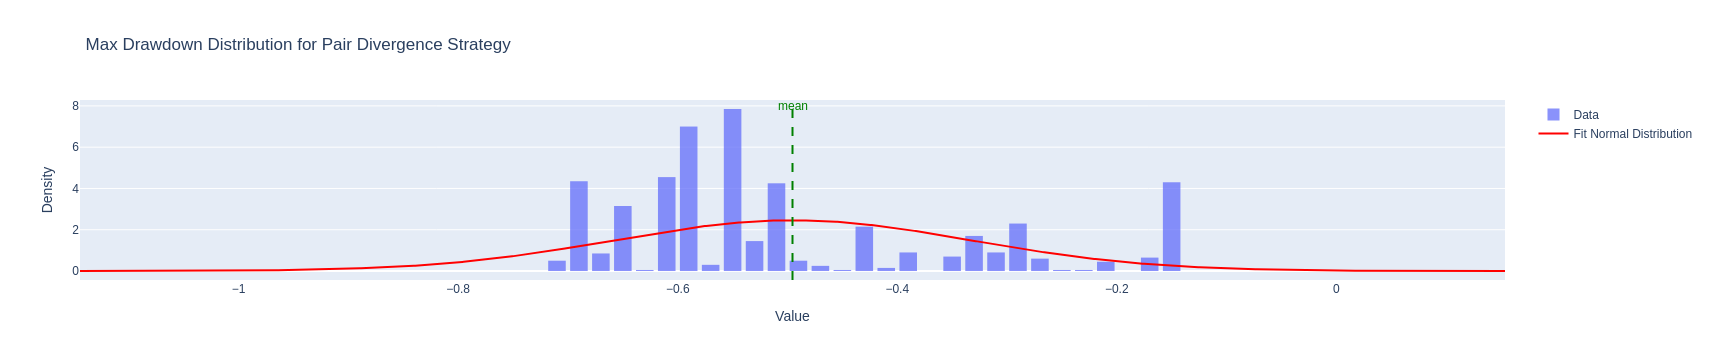

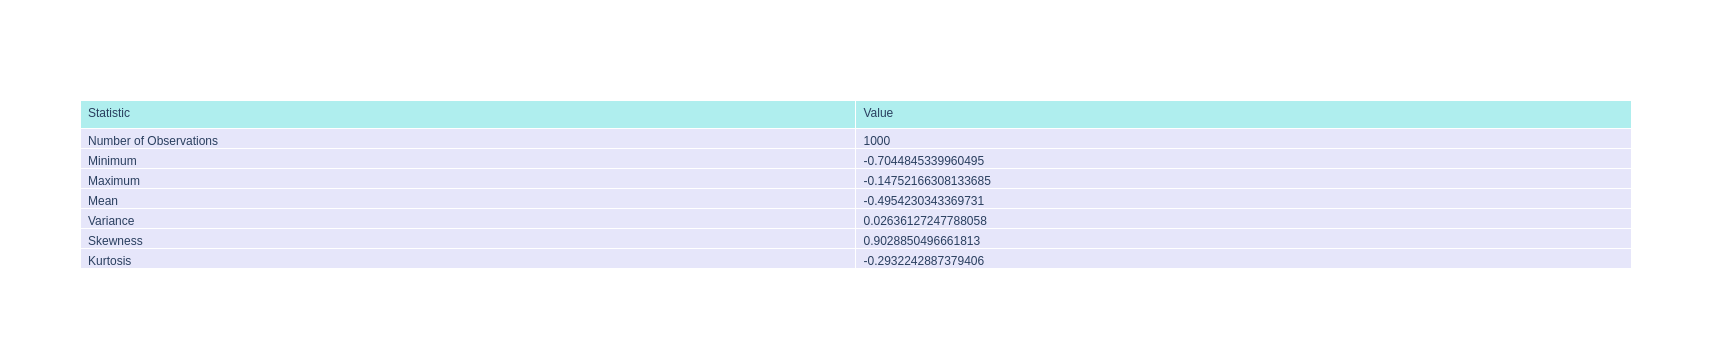

In [21]:
pair_max_drawdowns = [analysis.portfolio.max_drawdown() for analysis in pair_analyses]
plot_statistics(pair_max_drawdowns, title="Max Drawdown Distribution for Pair Divergence Strategy")
plot_table_statistics(pair_max_drawdowns)